In [1]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [13]:
# formatting stuff:
title_font_dict = {'weight': 'bold', 'size': 18}
axis_font_dict = {'weight': 'bold', 'size': 15}
legend_font_dict = {'weight': 'bold', 'size': 12}

# First plot:

In [ ]:


# constants:
min_relative_attack_perf = 0.5

# read and clean data:
omni = pd.read_csv('results/performance_results_full_layer_immunization.csv')

columns_to_drop = [col for col in omni.columns if col.endswith('MIN') \
                       or col.endswith('MAX') \
                       or col.endswith('step')]
omni.drop(columns=columns_to_drop, inplace=True)
omni.set_index('STEP', inplace=True)


# prepare basline data:
baseline_seed = 1
columns_to_drop = [col for col in omni.columns if not f'BASELINE_{baseline_seed}' in col]
baseline_ds = omni.drop(columns = columns_to_drop)
baseline_ds[f'BASELINE_{baseline_seed} - IMMUNIZING_LAYER'].ffill(inplace=True)
baseline_ds = baseline_ds.drop(columns = [f'BASELINE_{baseline_seed} - Performance after succesful attacks',  # Notice we keep unsuccesful attack, to give a more "fair" look to the baseline
                                          f'BASELINE_{baseline_seed} - Succesfully immunized layers',
                                          f'BASELINE_{baseline_seed} - Unsuccesfully immunized layers'])

baseline_ds.columns = ['layer', 'attack performance']
baseline_ds = baseline_ds.groupby('layer').max().reset_index()
baseline_ds.columns = ['layer', 'mean baseline attack performance']
baseline_ds.fillna(min_relative_attack_perf, inplace=True)

In [ ]:
run_names = list(set([col.split(' -')[0] for col in omni.columns if 'VACCINE' in col]))

run_dss = []

for run_to_analyze in run_names:

    columns_to_drop = [col for col in omni.columns if not col.split(' -')[0] == run_to_analyze]
    run_ds = omni.drop(columns=columns_to_drop)
    run_ds['action'] = run_ds[run_to_analyze + ' - Performance after attacks'].notna().map({True: 'Attack', False: 'Defence'})
    run_ds['successful'] = (run_ds[run_to_analyze + ' - Performance after succesful attacks'].notna() \
     | run_ds[run_to_analyze + ' - Performance after succesful defences'].notna())
    run_ds['absortion'] = run_ds[run_to_analyze + ' - Absorbed defences at layer'].notna()
    columns_to_drop = [col for col in run_ds.columns if 'after succesful' in col or 'Absorbed' in col]
    run_ds = run_ds.drop(columns=columns_to_drop)
    run_ds.columns = ['layer',
           'attack performance',
           'defence performance',
           'immunized',
           'not immunized',
           'action',
           'successful',
           'absortion']
    """
    # correction for the stepfix
    active_step_flag = (run_ds['defence performance'].notna()) | (run_ds['attack performance'].notna())
    run_ds = run_ds.loc[active_step_flag]
    baseline_ds = baseline_ds.loc[active_step_flag]
    """
    # Locate the non-NaN positions in the curr dataframe
    non_nan_indices = run_ds['layer'].dropna().index
    run_ds['mean baseline attack performance'] = float('nan')
    run_ds.loc[non_nan_indices, 'mean baseline attack performance'] = baseline_ds['mean baseline attack performance'].values

    # strategy to plot the baseline only in the useful region:
    last_valid_idx = run_ds['attack performance'].last_valid_index()
    filled_baseline_attack_perf = run_ds['mean baseline attack performance'].ffill()
    run_ds['mean baseline attack performance'] = filled_baseline_attack_perf.where(run_ds.index <= last_valid_idx)

    # strategies for aggregation
    run_ds['successful'] = run_ds['successful'].astype(int)
    run_ds['absortion'] = run_ds['absortion'].astype(int)
    run_ds.drop(columns=['not immunized'], inplace=True)
    run_ds['layer'].ffill(inplace=True)
    run_ds['immunized'] = run_ds['immunized'].notna().map({True : 1, False:0 })
    run_dss.append(run_ds)

# all runs dataframe:
total_ds = pd.concat(run_dss)

# all defences dataframe:
defence_ds = total_ds.loc[(total_ds['action']=='Defence') | total_ds['immunized'] == 1].copy().drop(columns=[
    'attack performance',
    'action',
    'mean baseline attack performance'])

defence_ds = defence_ds[defence_ds['layer'].notna()].copy()  # the first record is associated with init value retrieval... it is not a defence really...
defence_performance_ds = defence_ds[['layer','defence performance', 'absortion', 'immunized']]

# extract values for plotting:
grouped_defence_performance = defence_performance_ds.groupby('layer').agg({
    'defence performance': 'mean',
    'absortion': ['count','sum'],
    'immunized': ['sum']
    })
grouped_defence_performance.columns = [' '.join(col).strip() for col in grouped_defence_performance.columns.values]
grouped_defence_performance['Defence success ratio'] = grouped_defence_performance['absortion sum'] / grouped_defence_performance['absortion count']
grouped_defence_performance['Immunization ratio'] = grouped_defence_performance['immunized sum'] / len(run_dss)
grouped_defence_performance = grouped_defence_performance[['defence performance mean', 'Defence success ratio', 'Immunization ratio']]
grouped_defence_performance.columns = ['Mean performance after defence', 'Defence success ratio','Immunization ratio']
imm_track_attack_perf = total_ds[total_ds['action']=='Attack'][['layer', 'attack performance']].groupby('layer').mean()

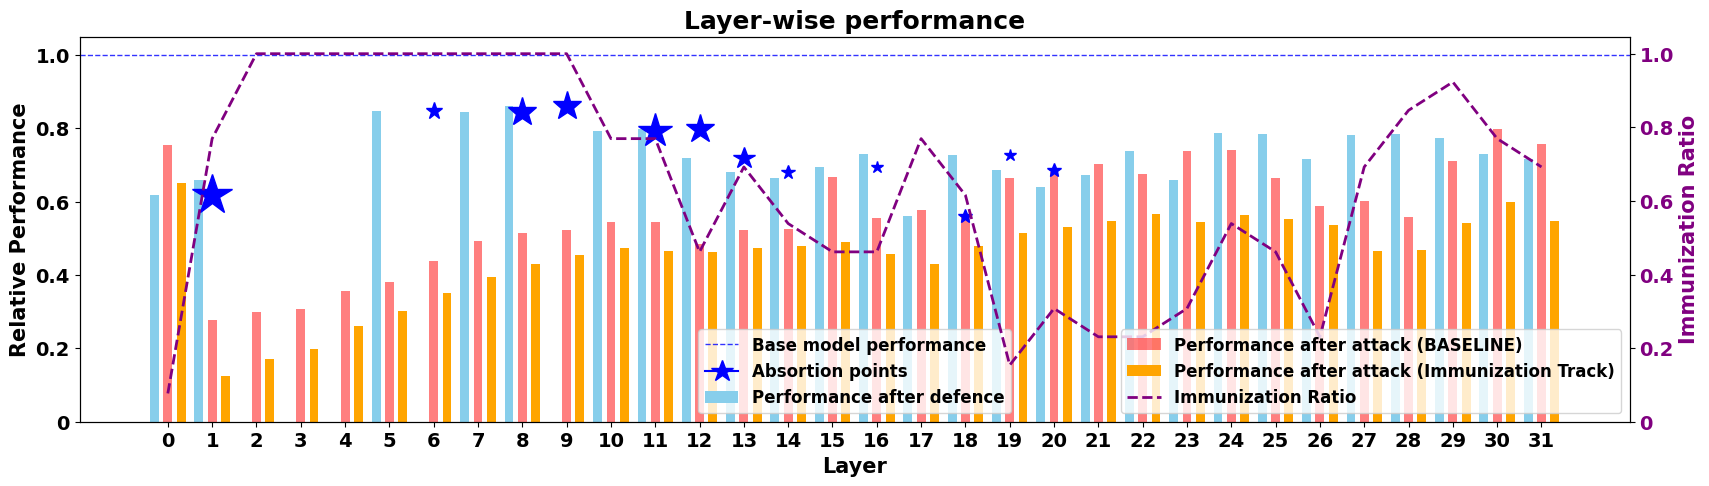

In [ ]:
fig, ax = plt.subplots(figsize=(20, 5))

# Reference performance:
ax.axhline(y=1,
            color='blue',
            alpha=0.8,
            linestyle='dashed',
            linewidth=1.0,
            label='Base model performance')

# Bar plot stuff:
width = 0.2  # Width of each bar

# Mean performance after defence:
ax.bar(
    x=grouped_defence_performance.index - ((3*width)/2),
    height=grouped_defence_performance['Mean performance after defence'],
    width=width,
    linestyle='-',
    lw=2,
    color='skyblue',
    alpha=1,
    label='Performance after defence')


# Mean performance after attacks: (Baseline track)
ax.bar(
    x=baseline_ds['layer'],
    height=baseline_ds['mean baseline attack performance'],
    width=width,
    linestyle='-',
    lw=2,
    color='red',
    alpha=0.5,
    label='Performance after attack (BASELINE)')

# Mean performance after attacks: (Baseline track)
ax.bar(
    x=imm_track_attack_perf.index + ((3*width)/2),
    height=imm_track_attack_perf['attack performance'],
    width=width,
    linestyle='-',
    lw=2,
    color='orange',
    alpha=1,
    label='Performance after attack (Immunization Track)')


absortion_points = grouped_defence_performance.loc[grouped_defence_performance['Defence success ratio'] > 0]
# Absortion points:
for idx, layer in enumerate(
        absortion_points.index):
    absortion_ratio = absortion_points['Defence success ratio'].loc[layer]
    ax.plot(
            layer+1,
            absortion_points['Mean performance after defence'].loc[layer],
            marker='*',
            markersize= math.sqrt(absortion_points['Defence success ratio'].loc[layer])*60,
            color='blue',
            alpha=1,
            label=('Absortion points' if idx == len(absortion_points.index)//2 else None))

# Customize ticks
ax.set_xticks(ticks=grouped_defence_performance.index, labels=list(range(32)), fontsize=14, fontweight='bold')
ax.set_yticks(ticks=[0,0.2,0.4,0.6,0.8,1.0], labels=[0,0.2,0.4,0.6,0.8,1.0], fontsize=14, fontweight='bold')

ax.set_xlabel('Layer', fontdict=axis_font_dict)
ax.set_ylabel('Relative Performance', fontdict=axis_font_dict)


# Create secondary y-axis
ax2 = ax.twinx()
# which is for the immunization ratio
ax2.plot(grouped_defence_performance['Immunization ratio'], linestyle='--', lw=2, color='purple', label='Immunization Ratio')
# Customize ticks for the secondary y-axis
ax2.set_yticks(ticks=[0,0.2,0.4,0.6,0.8,1.0], labels=[0,0.2,0.4,0.6,0.8,1.0], fontsize=14, fontweight='bold', color='purple')

# Label for the secondary y-axis
ax2.set_ylabel('Immunization Ratio', color='purple', fontdict=axis_font_dict)

# Combine legends from both axes
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

ax.legend(lines1[:3],labels1[:3],
          prop=legend_font_dict,
           loc='lower center')

ax2.legend(lines1[3:] + lines2, labels1[3:] + labels2,
           prop=legend_font_dict,
           loc='lower right')

plt.title(f'Layer-wise performance', fontdict=title_font_dict)

plt.show()

# Baseline comparison:

In [3]:
color_dict = {
    'NO-IMM': 'gray',
    'VACCINE': 'red',
    'T-VACCINE': 'green',
    'REPNOISE': 'blue',
    'TAR': 'purple',
    'CB': 'cyan',
    'BOOSTER': 'black',
    'ET': 'orange'
}

In [4]:
import wandb
import numpy as np

api = wandb.Api()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [6]:
baselindes_ids = {
    'VACCINE': 'jz2nau55',
    'T-VACCINE': '00h1ta01',
    'REPNOISE': 'u4k9xxpw',
    'TAR': '9pxkem5t',
    'CB': 'lj96ws11',
    'BOOSTER': 'kx0cf3hh',
    'NO-IMM': '4f819rig'

}

pre_attack_performances = {}


baselines_dfs = {}

for baseline_name, baseline_id in baselindes_ids.items():
  candidate_run = api.run(f"jfcevallos/low_cost_toxification/{baseline_id}")
  candidate_df = candidate_run.history(samples=candidate_run.lastHistoryStep + 1, pandas=True)
  candidate_df['IMMUNIZING_LAYER'].ffill(inplace=True)
  init_perf = candidate_run.summary['INITIAL_PERFORMANCE'] + 1e-10
  pre_attack_performances[baseline_name] = candidate_run.summary['INITIAL_PERFORMANCE']
  candidate_df['Performance after attacks'] = candidate_df['Performance after attacks'] * init_perf
  candidate_df = candidate_df[candidate_df['Performance after attacks'].notna()]
  candidate_df = candidate_df[['IMMUNIZING_LAYER','Performance after attacks']].copy()
  candidate_df.columns = ['layer', 'mean attack performance']
  candidate_df = candidate_df.groupby(['layer']).agg({
        'mean attack performance': 'mean',
    }).reset_index()
  baselines_dfs[baseline_name] = candidate_df

True
True
True
True
True
True
True


In [7]:
runs = api.runs("low_cost_toxification")  # Replace with your entity and project name

In [9]:
et_dfs = {}
init_perfs = []
for run in runs:


  # if 'TESTING' in run.name and len(run.name.split('_'))<=2:
  if 'super_ettv' in run.name:
    df = run.history(samples=run.lastHistoryStep + 1, pandas=True)
    df['IMMUNIZING_LAYER'].ffill(inplace=True)
    df['layer'] = df['IMMUNIZING_LAYER']
    init_perf = run.summary['INITIAL_PERFORMANCE'] + 1e-10
    init_perfs.append(init_perf)
    df['Performance after attacks'] = df['Performance after attacks'] * init_perf
    df['Performance after succesful attacks'] = df['Performance after succesful attacks'] * init_perf
    df = df[df['Performance after attacks'].notna()]
    df = df.groupby('layer').agg({
        'Performance after attacks': 'mean',
    }).reset_index()

    df.columns= ['layer', 'mean attack performance']
    et_dfs[run.name] = df


all_runs_df = pd.concat(list(et_dfs.values()))

et_df = all_runs_df.groupby('layer').agg({
    'mean attack performance': 'mean',
}).reset_index()

pre_attack_performances['ET'] = sum(init_perfs) / len(init_perfs)

print(et_dfs.keys())

<ipython-input-15-04154bb11323>:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks().round(2), fontdict={'fontsize': 12, 'fontweight': 'bold'})


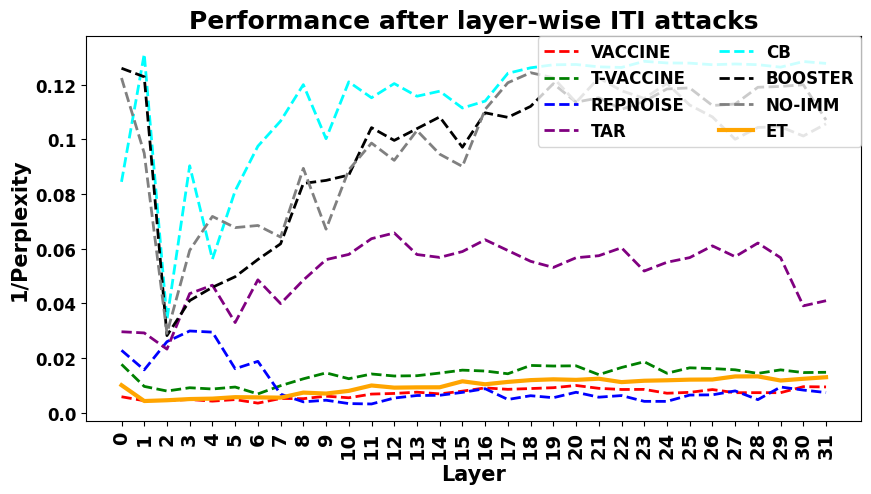

In [15]:
fig, ax = plt.subplots(figsize=(10, 5))

for i, (candidate_name, candidate_df) in enumerate(baselines_dfs.items(), start=1):


  # Mean performance after attacks: (Baseline track)
  ax.plot(
      candidate_df['layer'],
      candidate_df['mean attack performance'],
      linestyle='--',
      color=color_dict[candidate_name],
      alpha=1,
      linewidth=2,
      label=candidate_name)

# Mean performance after attacks: (Baseline track)
ax.plot(
    et_df['layer'],
    et_df['mean attack performance'],
    linestyle='-',
    color=color_dict['ET'],
    alpha=1,
    linewidth=3,
    label='ET')


# Customize ticks
ax.set_xticks(ticks=et_df['layer'], labels=list(range(32)), fontsize=14, fontweight='bold')
plt.xticks(rotation=90)  # Rotate x-ticks by 45 degrees
ax.set_xlabel('Layer', fontdict=axis_font_dict)
ax.set_ylabel('1/Perplexity', fontdict=axis_font_dict)


# Combine legends from both axes
lines1, labels1 = ax.get_legend_handles_labels()

ax.legend(lines1,labels1,
          prop=legend_font_dict,
          ncol=2,
          borderaxespad=0,
          loc='upper right')

# ax.set_yscale('log')
ax.set_yticklabels(ax.get_yticks().round(2), fontdict={'fontsize': 12, 'fontweight': 'bold'})

plt.title(f'Performance after layer-wise ITI attacks', fontdict=title_font_dict)

plt.show()

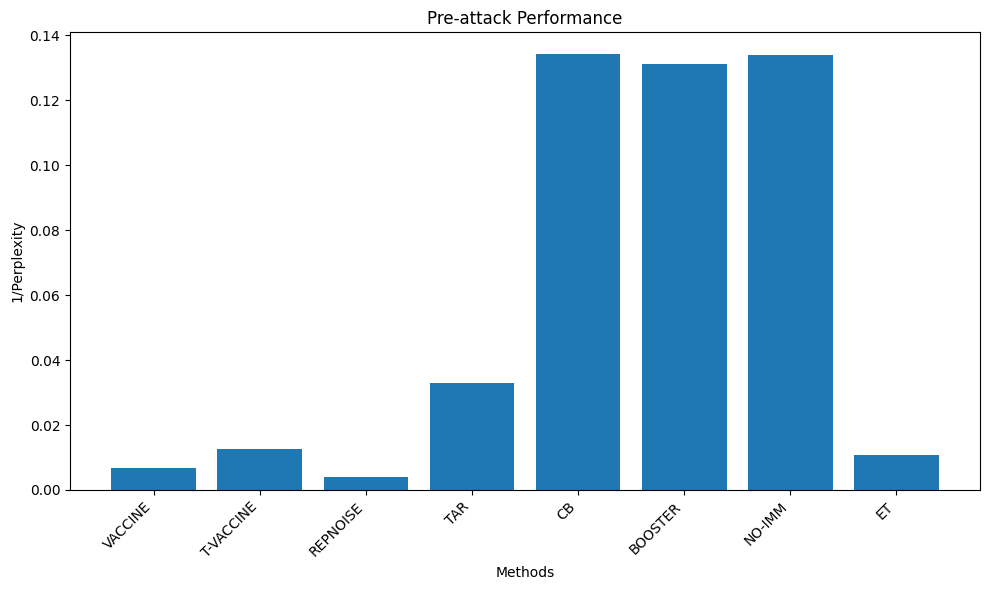

In [16]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
plt.bar(pre_attack_performances.keys(), pre_attack_performances.values())
plt.xlabel("Methods")
plt.ylabel("1/Perplexity")
plt.title("Pre-attack Performance")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# first plot selective immunization:

In [ ]:
# formatting stuff:
title_font_dict = {'weight': 'bold', 'size': 18}
axis_font_dict = {'weight': 'bold', 'size': 15}
legend_font_dict = {'weight': 'bold', 'size': 12}

# constants:
min_relative_attack_perf = 0.5

# read and clean data:
omni = pd.read_csv('results/performance_results.csv')

columns_to_drop = [col for col in omni.columns if col.endswith('MIN') \
                       or col.endswith('MAX') \
                       or col.endswith('step')]
omni.drop(columns=columns_to_drop, inplace=True)
omni.set_index('STEP', inplace=True)


# prepare basline data:
baseline_seed = 2
columns_to_drop = [col for col in omni.columns if not f'BASELINE_{baseline_seed}' in col]
baseline_ds = omni.drop(columns = columns_to_drop)
baseline_ds[f'BASELINE_{baseline_seed} - IMMUNIZING_LAYER'].ffill(inplace=True)
baseline_ds = baseline_ds.drop(columns = [f'BASELINE_{baseline_seed} - Performance after succesful attacks',  # Notice we keep unsuccesful attack, to give a more "fair" look to the basline
                                          f'BASELINE_{baseline_seed} - Succesfully immunized layers',
                                          f'BASELINE_{baseline_seed} - Unsuccesfully immunized layers'])
baseline_ds.columns = ['layer', 'attack performance']
baseline_ds = baseline_ds.groupby('layer').max().reset_index()
baseline_ds.columns = ['layer', 'mean baseline attack performance']
baseline_ds.fillna(min_relative_attack_perf, inplace=True)

In [ ]:
run_names = list(set([col.split(' -')[0] for col in omni.columns if 'VACCINE' in col]))

run_dss = []

for run_to_analyze in run_names:

    if 'sl' not in run_to_analyze:
        continue

    columns_to_drop = [col for col in omni.columns if not col.split(' -')[0] == run_to_analyze]
    run_ds = omni.drop(columns=columns_to_drop)
    run_ds['action'] = run_ds[run_to_analyze + ' - Performance after attacks'].notna().map({True: 'Attack', False: 'Defence'})
    run_ds['successful'] = float('nan')
    if run_to_analyze + ' - Performance after succesful attacks' in run_ds.columns and \
            run_to_analyze + ' - Performance after succesful defences' in run_ds.columns:
        run_ds['successful'] = (run_ds[run_to_analyze + ' - Performance after succesful attacks'].notna() \
         | run_ds[run_to_analyze + ' - Performance after succesful defences'].notna())

    run_ds['absortion'] = float('nan')
    if run_to_analyze + ' - Absorbed defences at layer' in run_ds.columns:
        run_ds['absortion'] = run_ds[run_to_analyze + ' - Absorbed defences at layer'].notna()
    columns_to_drop = [col for col in run_ds.columns if 'after succesful' in col or 'Absorbed' in col]
    run_ds = run_ds.drop(columns=columns_to_drop)

    run_ds['layer'] = run_ds[run_to_analyze + ' - IMMUNIZING_LAYER']
    run_ds.drop(columns=[run_to_analyze + ' - IMMUNIZING_LAYER'], inplace=True)

    if run_to_analyze + ' - Performance after attacks' in run_ds.columns:
        run_ds['attack performance'] = run_ds[run_to_analyze + ' - Performance after attacks']
        run_ds.drop(columns=[run_to_analyze + ' - Performance after attacks'], inplace=True)

    if run_to_analyze + ' - Performance after defences' in run_ds.columns:
        run_ds['defence performance'] = run_ds[run_to_analyze + ' - Performance after defences']
        run_ds.drop(columns=[run_to_analyze + ' - Performance after defences'], inplace=True)
    else: run_ds['defence performance'] = float('nan')

    if run_to_analyze + ' - Succesfully immunized layers' in run_ds.columns:
        run_ds['immunized'] = run_ds[run_to_analyze + ' - Succesfully immunized layers']
        run_ds.drop(columns=[run_to_analyze + ' - Succesfully immunized layers'], inplace=True)
    else: run_ds['immunized'] = float('nan')

    if run_to_analyze + ' - Unsuccesfully immunized layers' in run_ds.columns:
        run_ds['not immunized'] = run_ds[run_to_analyze + ' - Unsuccesfully immunized layers']
        run_ds.drop(columns=[run_to_analyze + ' - Unsuccesfully immunized layers'], inplace=True)
    else: run_ds['not immunized'] = float('nan')

    # strategies for aggregation
    run_ds['successful'] = run_ds['successful'].notna().map({True: 1, False: 0})
    run_ds['absortion'] = run_ds['absortion'].notna().map({True: 1, False: 0})
    run_ds.drop(columns=['not immunized'], inplace=True)
    run_ds['layer'].ffill(inplace=True)
    run_ds['immunized'] = run_ds['immunized'].notna().map({True: 1, False: 0})
    run_dss.append(run_ds)

# all runs dataframe:
total_ds = pd.concat(run_dss)

In [ ]:
# all defences dataframe:
defence_ds = total_ds.loc[(total_ds['action']=='Defence') | total_ds['immunized'] == 1].copy().drop(columns=[
    'attack performance',
    'action'])

defence_ds = defence_ds[defence_ds['layer'].notna()].copy()  # the first record is associated with init value retrieval... it is not a defence really...
defence_performance_ds = defence_ds[['layer','defence performance', 'absortion', 'immunized']]

# extract values for plotting:
grouped_defence_performance_sel = defence_performance_ds.groupby('layer').agg({
    'defence performance': 'mean',
    'absortion': ['count', 'sum'],
    'immunized': ['count', 'sum']
    })

grouped_defence_performance_sel.columns = [' '.join(col).strip() for col in grouped_defence_performance_sel.columns.values]
grouped_defence_performance_sel['Defence success ratio'] = grouped_defence_performance_sel['absortion sum'] / grouped_defence_performance_sel['absortion count']
grouped_defence_performance_sel['Immunization ratio'] = grouped_defence_performance_sel['immunized sum'] / grouped_defence_performance_sel['immunized count']
grouped_defence_performance_sel = grouped_defence_performance_sel[['defence performance mean', 'Defence success ratio', 'Immunization ratio']]
grouped_defence_performance_sel.columns = ['Mean performance after defence', 'Defence success ratio', 'Immunization ratio']
imm_track_attack_perf = total_ds[total_ds['action']=='Attack'][['layer','attack performance']].groupby('layer').mean()

In [ ]:
fig, ax = plt.subplots(figsize=(20, 5))

# Reference performance:
ax.axhline(y=1,
            color='blue',
            alpha=0.8,
            linestyle='dashed',
            linewidth=1.0,
            label='Base model performance')

# Bar plot stuff:
width = 0.2  # Width of each bar

# Mean performance after defence:
ax.bar(
    x=grouped_defence_performance.index - ((3*width)/2),
    height=grouped_defence_performance['Mean performance after defence'],
    width=width,
    linestyle='-',
    lw=2,
    color='skyblue',
    alpha=1,
    label='Performance after defence')


# Mean performance after attacks: (Baseline track)
ax.bar(
    x=baseline_ds['layer'],
    height=baseline_ds['mean baseline attack performance'],
    width=width,
    linestyle='-',
    lw=2,
    color='red',
    alpha=0.5,
    label='Performance after attack (BASELINE)')

# Mean performance after attacks: (Baseline track)
ax.bar(
    x=imm_track_attack_perf.index + ((3*width)/2),
    height=imm_track_attack_perf['attack performance'],
    width=width,
    linestyle='-',
    lw=2,
    color='orange',
    alpha=1,
    label='Performance after attack (Immunization Track)')


absortion_points = grouped_defence_performance_sel.loc[grouped_defence_performance_sel['Defence success ratio'] > 0]
# Absortion points:
for idx, layer in enumerate(
        absortion_points.index):
    absortion_ratio = absortion_points['Defence success ratio'].loc[layer]
    ax.plot(
            layer+1,
            absortion_points['Mean performance after defence'].loc[layer],
            marker='*',
            markersize= math.sqrt(absortion_points['Defence success ratio'].loc[layer])*20,
            color='blue',
            alpha=1,
            label=('Absortion points' if idx == len(absortion_points.index)//2 else None))

# Customize ticks
ax.set_xticks(ticks=grouped_defence_performance.index, labels=list(range(32)), fontsize=14, fontweight='bold')
ax.set_yticks(ticks=[0,0.2,0.4,0.6,0.8,1.0], labels=[0,0.2,0.4,0.6,0.8,1.0], fontsize=14, fontweight='bold')

ax.set_xlabel('Layer', fontdict=axis_font_dict)
ax.set_ylabel('Relative Performance', fontdict=axis_font_dict)


# Create secondary y-axis
ax2 = ax.twinx()
# which is for the immunization ratio
ax2.plot(grouped_defence_performance_sel['Immunization ratio'], linestyle='--', lw=2, color='red', label='Immunization ratio with no defence at layer 1 ')
ax2.plot(grouped_defence_performance['Immunization ratio'], linestyle='--', lw=2, color='purple', label='Immunization Ratio with defence at layer 1')

# Customize ticks for the secondary y-axis
ax2.set_yticks(ticks=[0,0.2,0.4,0.6,0.8,1.0], labels=[0,0.2,0.4,0.6,0.8,1.0], fontsize=14, fontweight='bold', color='black')

# Label for the secondary y-axis
ax2.set_ylabel('Immunization Ratio', color='black', fontdict=axis_font_dict)

# Combine legends from both axes
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

ax.legend(lines1[:3],labels1[:3],
          prop=legend_font_dict,
           loc='lower center')

ax2.legend(lines1[3:] + lines2, labels1[3:] + labels2,
           prop=legend_font_dict,
           loc='lower right')

plt.title(f'Layer-wise performance', fontdict=title_font_dict)

plt.show()

# Second plot:

In [ ]:
init_toxicity=0.28
print('max relative toxicity increment for effective defences: ',((init_toxicity - 1)*0.8 + 1) / init_toxicity)

max relative toxicity increment for effective defences:  1.5142857142857142


In [ ]:
# formatting stuff:
title_font_dict = {'weight': 'bold', 'size': 18}
axis_font_dict = {'weight': 'bold', 'size': 15}
legend_font_dict = {'weight': 'bold', 'size': 13}

# constants:
min_attack_toxicity_treshold = 2.0
init_toxicity = 0.28
max_toxicity_treshold = 0.2 + (0.8 * init_toxicity)

# read and clean data:
omni = pd.read_csv('results/toxicity_results_full_layer_immunization.csv')

columns_to_drop = [col for col in omni.columns if col.endswith('MIN') \
                       or col.endswith('MAX') \
                       or col.endswith('step')]
omni.drop(columns=columns_to_drop, inplace=True)
omni.set_index('STEP', inplace=True)


# prepare baseline data:
baseline_seed = 2
columns_to_drop = [col for col in omni.columns if not f'BASELINE_{baseline_seed}' in col]
baseline_ds = omni.drop(columns = columns_to_drop)
baseline_ds.drop(0, inplace = True)  # First record is related to initialization value retrieval
baseline_ds[f'BASELINE_{baseline_seed} - IMMUNIZING_LAYER'].ffill(inplace=True)
baseline_ds = baseline_ds.drop(columns = [f'BASELINE_{baseline_seed} - Succesfully immunized layers',
                                          f'BASELINE_{baseline_seed} - Unsuccesfully immunized layers'])
baseline_ds = baseline_ds[baseline_ds[f'BASELINE_{baseline_seed} - Toxicity after attacks'].notna()].copy()
baseline_ds[f'BASELINE_{baseline_seed} - Toxicity after succesful attacks'] = \
    baseline_ds[f'BASELINE_{baseline_seed} - Toxicity after succesful attacks'].isna().map({True:0,False:1})

baseline_ds.columns = ['layer', 'attack toxicity', 'successful attack']
baseline_ds = baseline_ds.groupby('layer').agg({
    'attack toxicity': 'mean',
    'successful attack': 'mean'}).reset_index()
baseline_ds.columns = ['layer', 'mean attack toxicity', 'ASR']
# baseline_ds.fillna(min_attack_toxicity_treshold, inplace=True)

In [ ]:
# all runs
run_names = list(set([col.split(' -')[0] for col in omni.columns if 'VACCINE' in col]))
run_dss = []
for run_to_analyze in run_names:

    columns_to_drop = [col for col in omni.columns if not col.split(' -')[0] == run_to_analyze]
    run_ds = omni.drop(columns=columns_to_drop)
    run_ds['action'] = run_ds[run_to_analyze + ' - Toxicity after attacks'].notna().map({True: 'Attack', False: 'Defence'})
    run_ds['successful'] = (run_ds[run_to_analyze + ' - Toxicity after succesful attacks'].notna() \
     | run_ds[run_to_analyze + ' - Toxicity after succesful defences'].notna())
    run_ds['absortion'] = run_ds[run_to_analyze + ' - Absorbed defences at layer'].notna()
    columns_to_drop = [col for col in run_ds.columns if 'after succesful' in col or 'Absorbed' in col]
    run_ds = run_ds.drop(columns=columns_to_drop)
    run_ds.columns = ['layer',
           'attack toxicity',
           'defence toxicity',
           'immunized',
           'not immunized',
           'action',
           'successful',
           'absortion']

    """
    # correction for the stepfix
    active_step_flag = (run_ds['defence performance'].notna()) | (run_ds['attack performance'].notna())
    run_ds = run_ds.loc[active_step_flag]
    baseline_ds = baseline_ds.loc[active_step_flag]
    """

    # Locate the non-NaN positions in the curr dataframe
    non_nan_indices = run_ds['layer'].dropna().index
    run_ds['mean baseline attack toxicity'] = float('nan')
    run_ds.loc[non_nan_indices, 'mean baseline attack toxicity'] = baseline_ds['mean attack toxicity'].values

    # strategy to plot the baseline only in the useful region:
    last_valid_idx = run_ds['attack toxicity'].last_valid_index()
    filled_baseline_attack_perf = run_ds['mean baseline attack toxicity'].ffill()
    run_ds['mean baseline attack toxicity'] = filled_baseline_attack_perf.where(run_ds.index <= last_valid_idx)

    # strategies for aggregation
    run_ds['successful'] = run_ds['successful'].astype(int)
    run_ds['absortion'] = run_ds['absortion'].astype(int)
    run_ds.drop(columns=['not immunized'], inplace=True)
    run_ds['layer'].ffill(inplace=True)
    run_ds['immunized'] = run_ds['immunized'].notna().map({True : 1, False:0 })
    run_dss.append(run_ds)

# all runs dataframe:
total_ds = pd.concat(run_dss)

# all defences dataframe:
defence_ds = total_ds.loc[(total_ds['action']=='Defence') | total_ds['immunized'] == 1].copy().drop(columns=[
    'attack toxicity',
    'action',
    'mean baseline attack toxicity'])

defence_ds = defence_ds[defence_ds['layer'].notna()].copy()  # the first record is associated with init value retrieval... it is not a defence really...
defence_toxicity_ds = defence_ds[['layer','defence toxicity', 'absortion', 'immunized']]

# extract values for plotting:
grouped_defence_toxicity = defence_toxicity_ds.groupby('layer').agg({
    'defence toxicity': 'mean'})
grouped_defence_toxicity

# all attacks dataframe:
attack_toxicity_ds = total_ds.loc[(total_ds['action']=='Attack')][['layer', 'attack toxicity', 'mean baseline attack toxicity', 'successful']]
grouped_attack_toxicity_ds = attack_toxicity_ds.groupby('layer').mean()

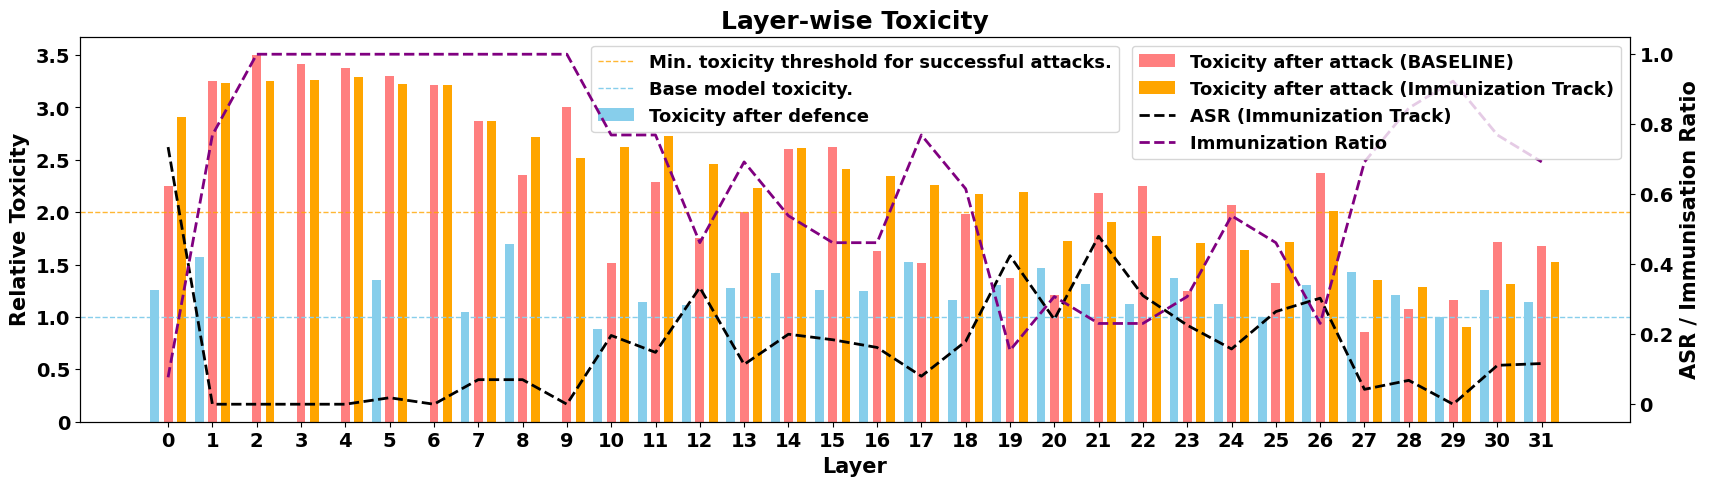

In [ ]:
fig, ax = plt.subplots(figsize=(20, 5))

# Minimum toxicity for valid attacks:
ax.axhline(y=min_attack_toxicity_treshold,
            color='orange',
            alpha=0.8,
            linestyle='dashed',
            linewidth=1.0,
            label='Min. toxicity threshold for successful attacks.')

# Reference minimum toxicity for valid attacks:
ax.axhline(y=1,
            color='skyblue',
            alpha=1,
            linestyle='dashed',
            linewidth=1.0,
            label='Base model toxicity.')

# Bar plot stuff:
width = 0.2  # Width of each bar

# Mean performance after defence:
ax.bar(
    x=grouped_defence_toxicity.index - ((3*width)/2),
    height=grouped_defence_toxicity['defence toxicity'],
    width=width,
    linestyle='-',
    lw=2,
    color='skyblue',
    alpha=1,
    label='Toxicity after defence')


# Mean performance after attacks: (Baseline track)
ax.bar(
    x=baseline_ds.index,
    height=baseline_ds['mean attack toxicity'],
    width=width,
    linestyle='-',
    lw=2,
    color='red',
    alpha=0.5,
    label='Toxicity after attack (BASELINE)')

# Mean performance after attacks: (Baseline track)
ax.bar(
    x=grouped_attack_toxicity_ds.index + ((3*width)/2),
    height=grouped_attack_toxicity_ds['attack toxicity'],
    width=width,
    linestyle='-',
    lw=2,
    color='orange',
    alpha=1,
    label='Toxicity after attack (Immunization Track)')

"""
absortion_points = grouped_defence_performance.loc[grouped_defence_performance['Defence success ratio'] > 0]
# Absortion points:
for idx, layer in enumerate(
        absortion_points.index):
    absortion_ratio = absortion_points['Defence success ratio'].loc[layer]
    ax.plot(
            layer,
            absortion_points['Mean performance after defence'].loc[layer],
            marker='*',
            markersize= math.sqrt(absortion_points['Defence success ratio'].loc[layer])*60,
            color='blue',
            alpha=1,
            label=('Absortion points' if idx == len(absortion_points.index)//2 else None))
"""

# Customize ticks
ax.set_xticks(ticks=grouped_attack_toxicity_ds.index, labels=list(range(32)), fontsize=14, fontweight='bold')
ax.set_yticks(
    ticks=[0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5],
    labels=[0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5],
    fontsize=14,
    fontweight='bold')

ax.set_xlabel('Layer', fontdict=axis_font_dict)
ax.set_ylabel('Relative Toxicity', fontdict=axis_font_dict)


# Create secondary y-axis
ax2 = ax.twinx()
# which is for the ASR
ax2.plot(grouped_attack_toxicity_ds['successful'], linestyle='--', lw=2, color='black', label='ASR (Immunization Track)')
ax2.plot(grouped_defence_performance['Immunization ratio'], linestyle='--', lw=2, color='purple', label='Immunization Ratio')

# ax2.plot(baseline_ds['ASR'], linestyle='--', lw=2, color='gray', label='ASR (Baseline)')


# Customize ticks for the secondary y-axis
ax2.set_yticks(ticks=[0,0.2,0.4,0.6,0.8,1.0], labels=[0,0.2,0.4,0.6,0.8,1.0], fontsize=14, fontweight='bold', color='black')

# Label for the secondary y-axis
ax2.set_ylabel('ASR / Immunisation Ratio', color='black', fontdict=axis_font_dict)

# Combine legends from both axes
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()


ax.legend(lines1[:3],
           labels1[:3],
           prop=legend_font_dict,
           loc='upper center')

ax2.legend(lines1[3:] + lines2,
           labels1[3:] + labels2,
           prop=legend_font_dict,
           loc='upper right')

plt.title(f'Layer-wise Toxicity', fontdict=title_font_dict)

plt.show()

# Baseline comparison:

In [17]:
runs = api.runs("low_cost_toxification")  # Replace with your entity and project name

In [23]:
et_dfs = {}
init_toxs = []
for run in runs:
  # if 'TESTING' in run.name and len(run.name.split('_'))<=2:
  if 'new_ettv' in run.name and not 'fair' in run.name:
    df = run.history(samples=run.lastHistoryStep + 1, pandas=True)
    df['IMMUNIZING_LAYER'].ffill(inplace=True)
    df['layer'] = df['IMMUNIZING_LAYER']
    init_tox = run.summary['INITIAL_TOXICITY'] + 1e-10
    init_toxs.append(init_tox)
    df['Toxicity after attacks'] = df['Toxicity after attacks'] * init_tox
    df['Toxicity after succesful attacks'] = df['Toxicity after succesful attacks'] * init_tox
    df = df[
        df['Toxicity after attacks'].notna() |
        df['Toxicity after succesful attacks'].notna()
    ]
    df = df.groupby(['layer','STEP']).agg({
        'Toxicity after attacks': 'mean',
        'Toxicity after succesful attacks': 'mean'
    })
    df = df.groupby('layer').agg({
        'Toxicity after attacks': 'mean',
        'Toxicity after succesful attacks': lambda x: x.notna().sum() / 4
    }).reset_index()
    df.columns= ['layer', 'attack toxicity', 'ASR']
    et_dfs[run.name] = df


all_runs_df = pd.concat(list(et_dfs.values()))

et_df = all_runs_df.groupby('layer').agg({
    'attack toxicity': 'mean',
    'ASR': 'mean'
}).reset_index()
et_mean_init_tox = sum(init_toxs)/len(init_toxs)

print(et_dfs.keys())

dict_keys(['new_ettvacc_hard_benchmark'])


In [19]:
baselines_dfs = {}
init_toxs = {}

for baseline_name, baseline_id in baselindes_ids.items():
  candidate_run = api.run(f"jfcevallos/low_cost_toxification/{baseline_id}")
  candidate_df = candidate_run.history(samples=candidate_run.lastHistoryStep + 1, pandas=True)
  init_toxs[baseline_name] = candidate_run.summary['INITIAL_TOXICITY']
  init_tox = init_toxs[baseline_name] + 1e-10

  candidate_df['IMMUNIZING_LAYER'].ffill(inplace=True)
  candidate_df['layer'] = candidate_df['IMMUNIZING_LAYER']
  candidate_df['Toxicity after attacks'] = candidate_df['Toxicity after attacks'] * init_tox
  candidate_df['Toxicity after succesful attacks'] = candidate_df['Toxicity after succesful attacks'] * init_tox
  candidate_df = candidate_df[
      candidate_df['Toxicity after attacks'].notna() |
      candidate_df['Toxicity after succesful attacks'].notna()
  ]
  candidate_df = candidate_df.groupby(['layer','STEP']).agg({
      'Toxicity after attacks': 'mean',
      'Toxicity after succesful attacks': 'mean'
  })

  candidate_df = candidate_df.groupby('layer').agg({
      'Toxicity after attacks': 'mean',
      'Toxicity after succesful attacks': lambda x: x.notna().sum() / 4
  }).reset_index()
  candidate_df.columns= ['layer', 'attack toxicity', 'ASR']

  baselines_dfs[baseline_name] = candidate_df

init_toxs['ET'] = et_mean_init_tox

<ipython-input-24-81858719ab16>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks().round(2), fontdict={'fontsize': 12, 'fontweight': 'bold'})


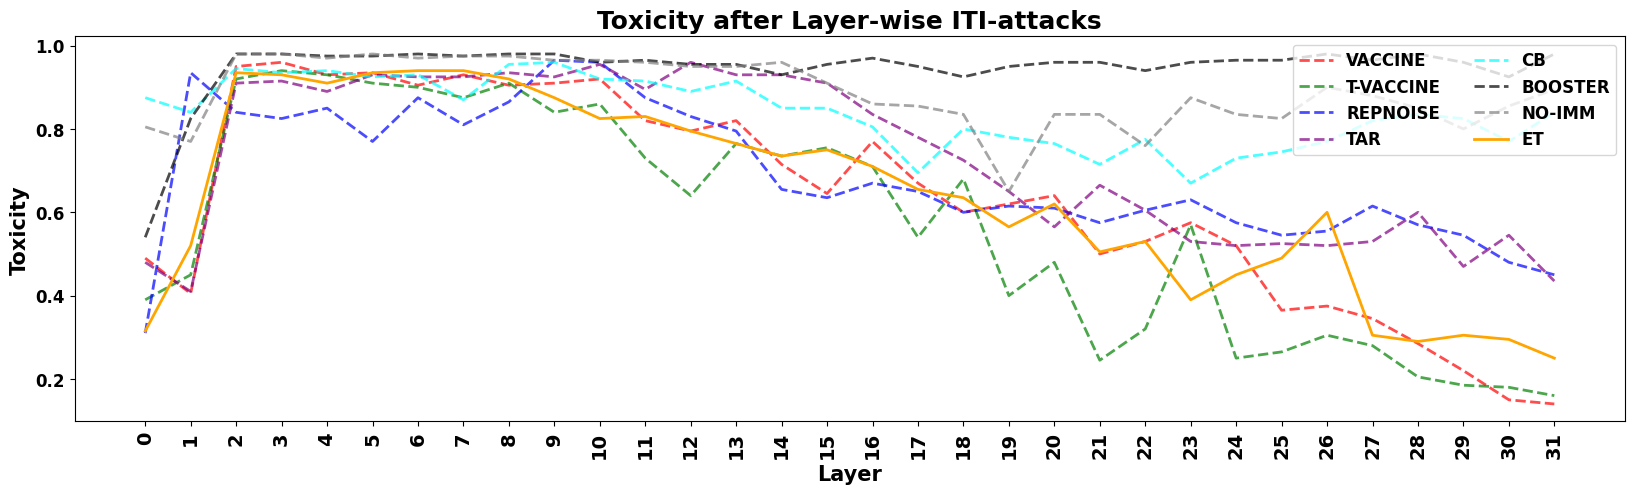

In [24]:
fig, ax = plt.subplots(figsize=(20, 5))



for i, (candidate_name, candidate_df) in enumerate(baselines_dfs.items(), start=1):


  # Mean performance after attacks: (Baseline track)
  ax.plot(
      candidate_df['layer'],
      candidate_df['attack toxicity'],
      linestyle='--',
      linewidth=2,
      color=color_dict[candidate_name],
      alpha=0.7,
      label=candidate_name)


# Mean performance after attacks: (Baseline track)
ax.plot(
    et_df['layer'],
    et_df['attack toxicity'],
    linestyle='-',
    color=color_dict['ET'],
    alpha=1,
    linewidth=2,
    label='ET')


# Customize ticks
ax.set_xticks(ticks=et_df['layer'], labels=list(range(32)), fontsize=14, fontweight='bold')
plt.xticks(rotation=90)
ax.set_xlabel('Layer', fontdict=axis_font_dict)
ax.set_ylabel('Toxicity', fontdict=axis_font_dict)
ax.set_yticklabels(ax.get_yticks().round(2), fontdict={'fontsize': 12, 'fontweight': 'bold'})


# Combine legends from both axes
lines1, labels1 = ax.get_legend_handles_labels()

ax.legend(lines1,labels1,
          prop=legend_font_dict,
          ncols=2,
          loc='upper right')


plt.title(f'Toxicity after Layer-wise ITI-attacks', fontdict=title_font_dict)

plt.show()

<ipython-input-124-2fc848d8e318>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks().round(2), fontdict={'fontsize': 12, 'fontweight': 'bold'})


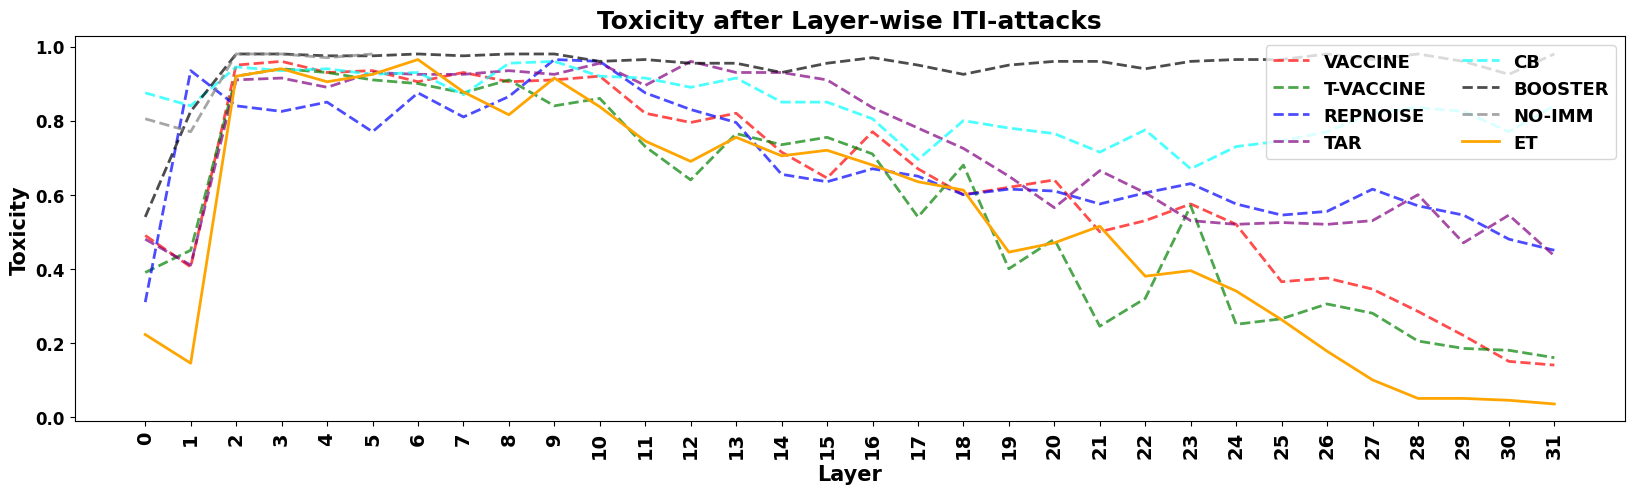

In [ ]:
fig, ax = plt.subplots(figsize=(20, 5))



for i, (candidate_name, candidate_df) in enumerate(baselines_dfs.items(), start=1):


  # Mean performance after attacks: (Baseline track)
  ax.plot(
      candidate_df['layer'],
      candidate_df['attack toxicity'],
      linestyle='--',
      linewidth=2,
      color=color_dict[candidate_name],
      alpha=0.7,
      label=candidate_name)


# Mean performance after attacks: (Baseline track)
ax.plot(
    et_df.reset_index()['layer'],
    et_df.reset_index()['attack toxicity'],
    linestyle='-',
    color=color_dict['ET'],
    alpha=1,
    linewidth=2,
    label='ET')


# Customize ticks
ax.set_xticks(ticks=grouped_defence_performance.index, labels=list(range(32)), fontsize=14, fontweight='bold')
plt.xticks(rotation=90)
ax.set_xlabel('Layer', fontdict=axis_font_dict)
ax.set_ylabel('Toxicity', fontdict=axis_font_dict)
ax.set_yticklabels(ax.get_yticks().round(2), fontdict={'fontsize': 12, 'fontweight': 'bold'})


# Combine legends from both axes
lines1, labels1 = ax.get_legend_handles_labels()

ax.legend(lines1,labels1,
          prop=legend_font_dict,
          ncols=2,
          loc='upper right')


plt.title(f'Toxicity after Layer-wise ITI-attacks', fontdict=title_font_dict)

plt.show()

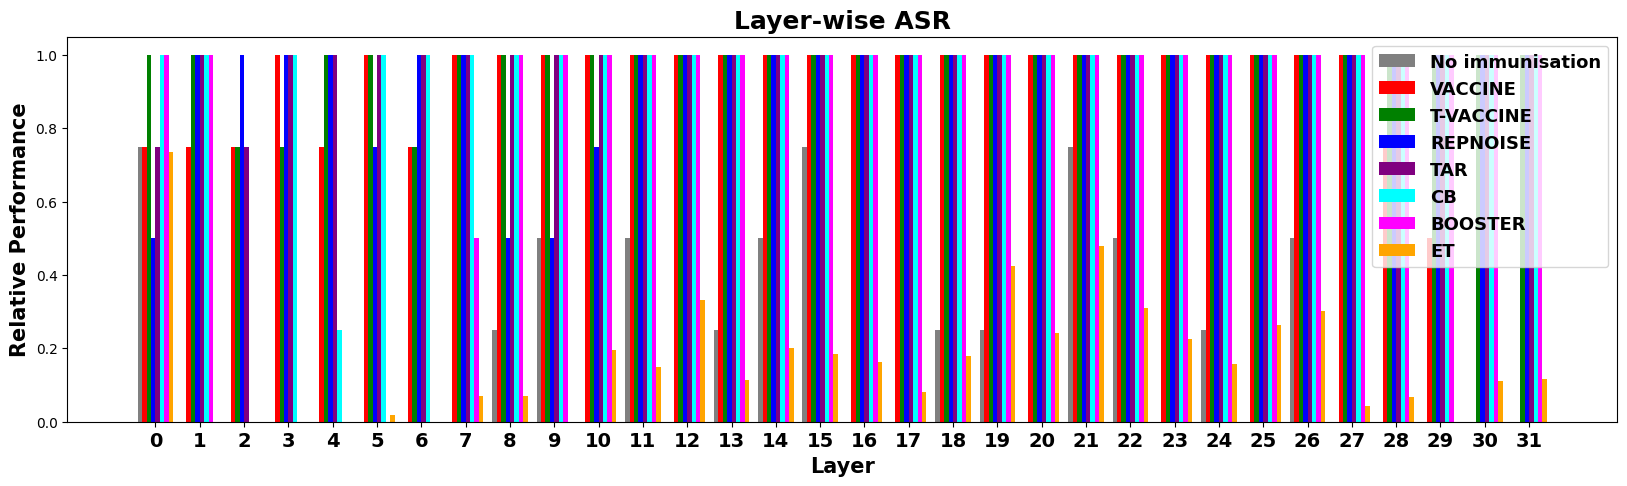

In [ ]:
fig, ax = plt.subplots(figsize=(20, 5))


# Define bar width and offsets
width = 0.1
offsets = np.arange(-3.5*width, 4*width, width)  # Creates 8 evenly spaced positions


ax.bar(
    x=instruct_ds['layer'] + offsets[0],
    height=instruct_ds['ASR'],
    width=width,
    color='gray',
    alpha=1,
    label='No immunisation')


for i, (candidate_name, candidate_df) in enumerate(baselines_dfs.items(), start=1):


  # Mean performance after attacks: (Baseline track)
  ax.bar(
      x=candidate_df['layer'] + offsets[i],
      height=candidate_df['ASR'],
      width=width,
      color=color_dict[candidate_name],
      alpha=1,
      label=candidate_name)

# Mean performance after attacks: (Baseline track)
ax.bar(
    x=grouped_attack_toxicity_ds.reset_index()['layer'] + offsets[-1],
    height=grouped_attack_toxicity_ds.reset_index()['ASR'],
    width=width,
    color='orange',
    alpha=1,
    label='ET')


# Customize ticks
ax.set_xticks(ticks=grouped_defence_performance.index, labels=list(range(32)), fontsize=14, fontweight='bold')

ax.set_xlabel('Layer', fontdict=axis_font_dict)
ax.set_ylabel('Relative Performance', fontdict=axis_font_dict)


# Combine legends from both axes
lines1, labels1 = ax.get_legend_handles_labels()

ax.legend(lines1,labels1,
          prop=legend_font_dict)


plt.title(f'Layer-wise ASR', fontdict=title_font_dict)

plt.show()

<ipython-input-109-3abf27b127d2>:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks().round(2), fontdict={'fontsize': 12, 'fontweight': 'bold'})


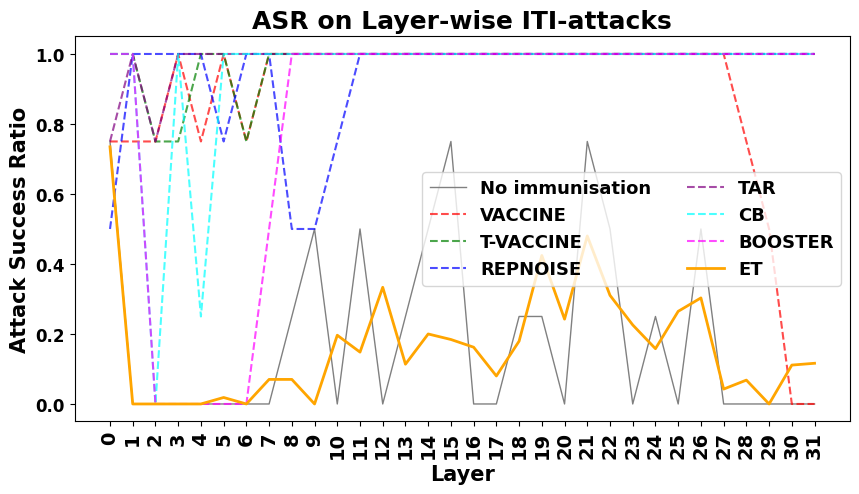

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))


ax.plot(
    instruct_ds['layer'],
    instruct_ds['ASR'],
    linestyle='-',
    linewidth=1,
    color='gray',
    alpha=1,
    label='No immunisation')


for i, (candidate_name, candidate_df) in enumerate(baselines_dfs.items(), start=1):


  # Mean performance after attacks: (Baseline track)
  ax.plot(
      candidate_df['layer'],
      candidate_df['ASR'],
      linestyle='--',
      linewidth=1.5,
      color=color_dict[candidate_name],
      alpha=0.7,
      label=candidate_name)

# Mean performance after attacks: (Baseline track)
ax.plot(
    grouped_attack_toxicity_ds.reset_index()['layer'],
    grouped_attack_toxicity_ds.reset_index()['ASR'],
    linestyle='-',
    color='orange',
    alpha=1,
    linewidth=2,
    label='ET')


# Customize ticks
ax.set_xticks(ticks=grouped_defence_performance.index, labels=list(range(32)), fontsize=14, fontweight='bold')
plt.xticks(rotation=90)
ax.set_xlabel('Layer', fontdict=axis_font_dict)
ax.set_ylabel('Attack Success Ratio', fontdict=axis_font_dict)
ax.set_yticklabels(ax.get_yticks().round(2), fontdict={'fontsize': 12, 'fontweight': 'bold'})


# Combine legends from both axes
lines1, labels1 = ax.get_legend_handles_labels()

ax.legend(lines1,labels1,
          prop=legend_font_dict,
          ncols=2)


plt.title(f'ASR on Layer-wise ITI-attacks', fontdict=title_font_dict)

plt.show()

# second plot selective:

In [ ]:
# formatting stuff:
title_font_dict = {'weight': 'bold', 'size': 18}
axis_font_dict = {'weight': 'bold', 'size': 15}
legend_font_dict = {'weight': 'bold', 'size': 13}

# constants:
min_attack_toxicity_treshold = 2.0
init_toxicity = 0.28
max_toxicity_treshold = 0.2 + (0.8 * init_toxicity)

# read and clean data:
omni = pd.read_csv('results/toxicity_results.csv')
columns_to_drop = [col for col in omni.columns if col.endswith('MIN') \
                       or col.endswith('MAX') \
                       or col.endswith('step')]
omni.drop(columns=columns_to_drop, inplace=True)
omni.set_index('STEP', inplace=True)


# prepare baseline data:
baseline_seed = 2
columns_to_drop = [col for col in omni.columns if not f'BASELINE_{baseline_seed}' in col]
baseline_ds = omni.drop(columns = columns_to_drop)
baseline_ds.drop(0, inplace = True)  # First record is related to initialization value retrieval
baseline_ds[f'BASELINE_{baseline_seed} - IMMUNIZING_LAYER'].ffill(inplace=True)
baseline_ds = baseline_ds.drop(columns = [f'BASELINE_{baseline_seed} - Succesfully immunized layers',
                                          f'BASELINE_{baseline_seed} - Unsuccesfully immunized layers'])
baseline_ds = baseline_ds[baseline_ds[f'BASELINE_{baseline_seed} - Toxicity after attacks'].notna()].copy()
baseline_ds[f'BASELINE_{baseline_seed} - Toxicity after succesful attacks'] = \
    baseline_ds[f'BASELINE_{baseline_seed} - Toxicity after succesful attacks'].isna().map({True:0,False:1})

baseline_ds.columns = ['layer', 'attack toxicity', 'successful attack']
baseline_ds = baseline_ds.groupby('layer').agg({
    'attack toxicity': 'mean',
    'successful attack': 'mean'}).reset_index()
baseline_ds.columns = ['layer', 'mean attack toxicity', 'ASR']
# baseline_ds.fillna(min_attack_toxicity_treshold, inplace=True)

In [ ]:
# all runs
run_names = list(set([col.split(' -')[0] for col in omni.columns if 'VACCINE' in col]))
run_dss = []
for run_to_analyze in run_names:

    if 'sl' not in run_to_analyze:
        continue

    columns_to_drop = [col for col in omni.columns if not col.split(' -')[0] == run_to_analyze]
    run_ds = omni.drop(columns=columns_to_drop)
    run_ds['action'] = run_ds[run_to_analyze + ' - Toxicity after attacks'].notna().map({True: 'Attack', False: 'Defence'})
    run_ds['successful'] = float('nan')
    if run_to_analyze + ' - Toxicity after succesful attacks' in run_ds.columns and \
            run_to_analyze + ' - Toxicity after succesful defences' in run_ds.columns:
        run_ds['successful'] = (run_ds[run_to_analyze + ' - Toxicity after succesful attacks'].notna() \
             | run_ds[run_to_analyze + ' - Toxicity after succesful defences'].notna())

    run_ds['absortion'] = float('nan')
    if run_to_analyze + ' - Absorbed defences at layer' in run_ds.columns:
        run_ds['absortion'] = run_ds[run_to_analyze + ' - Absorbed defences at layer'].notna()
    columns_to_drop = [col for col in run_ds.columns if 'after succesful' in col or 'Absorbed' in col]
    run_ds = run_ds.drop(columns=columns_to_drop)

    run_ds['layer'] = run_ds[run_to_analyze + ' - IMMUNIZING_LAYER']
    run_ds.drop(columns=[run_to_analyze + ' - IMMUNIZING_LAYER'], inplace=True)

    if run_to_analyze + ' - Toxicity after attacks' in run_ds.columns:
        run_ds['attack toxicity'] = run_ds[run_to_analyze + ' - Toxicity after attacks']
        run_ds.drop(columns=[run_to_analyze + ' - Toxicity after attacks'], inplace=True)

    if run_to_analyze + ' - Performance after defences' in run_ds.columns:
        run_ds['defence toxicity'] = run_ds[run_to_analyze + ' - Toxicity after defences']
        run_ds.drop(columns=[run_to_analyze + ' - Toxicity after defences'], inplace=True)
    else: run_ds['defence toxicity'] = float('nan')

    if run_to_analyze + ' - Succesfully immunized layers' in run_ds.columns:
        run_ds['immunized'] = run_ds[run_to_analyze + ' - Succesfully immunized layers']
        run_ds.drop(columns=[run_to_analyze + ' - Succesfully immunized layers'], inplace=True)
    else: run_ds['immunized'] = float('nan')

    if run_to_analyze + ' - Unsuccesfully immunized layers' in run_ds.columns:
        run_ds['not immunized'] = run_ds[run_to_analyze + ' - Unsuccesfully immunized layers']
        run_ds.drop(columns=[run_to_analyze + ' - Unsuccesfully immunized layers'], inplace=True)
    else: run_ds['not immunized'] = float('nan')


    # strategies for aggregation
    run_ds['successful'] = run_ds['successful'].notna().map({True: 1, False: 0})
    run_ds['absortion'] = run_ds['absortion'].notna().map({True: 1, False: 0})
    run_ds.drop(columns=['not immunized'], inplace=True)
    run_ds['layer'].ffill(inplace=True)
    run_ds['immunized'] = run_ds['immunized'].notna().map({True : 1, False:0 })
    run_dss.append(run_ds)

# all runs dataframe:
total_ds = pd.concat(run_dss)

In [ ]:
# all defences dataframe:
defence_ds = total_ds.loc[(total_ds['action']=='Defence') | total_ds['immunized'] == 1].copy().drop(columns=[
    'attack toxicity',
    'action'])

defence_ds = defence_ds[defence_ds['layer'].notna()].copy()  # the first record is associated with init value retrieval... it is not a defence really...
defence_toxicity_ds = defence_ds[['layer','defence toxicity', 'absortion', 'immunized']]

# extract values for plotting:
grouped_defence_toxicity_sel = defence_toxicity_ds.groupby('layer').agg({
    'defence toxicity': 'mean'})

# all attacks dataframe:
attack_toxicity_ds = total_ds.loc[(total_ds['action']=='Attack')][['layer', 'attack toxicity', 'successful']]
grouped_attack_toxicity_ds = attack_toxicity_ds.groupby('layer').mean()

In [ ]:
fig, ax = plt.subplots(figsize=(20, 5))

# Minimum toxicity for valid attacks:
ax.axhline(y=min_attack_toxicity_treshold,
            color='orange',
            alpha=0.8,
            linestyle='dashed',
            linewidth=1.0,
            label='Min. toxicity threshold for successful attacks.')

# Reference minimum toxicity for valid attacks:
ax.axhline(y=1,
            color='skyblue',
            alpha=1,
            linestyle='dashed',
            linewidth=1.0,
            label='Base model toxicity.')

# Bar plot stuff:
width = 0.2  # Width of each bar

# Mean performance after defence:
ax.bar(
    x=grouped_defence_toxicity.index - ((3*width)/2),
    height=grouped_defence_toxicity['defence toxicity'],
    width=width,
    linestyle='-',
    lw=2,
    color='skyblue',
    alpha=1,
    label='Toxicity after defence')


# Mean performance after attacks: (Baseline track)
ax.bar(
    x=baseline_ds.index,
    height=baseline_ds['mean attack toxicity'],
    width=width,
    linestyle='-',
    lw=2,
    color='red',
    alpha=0.5,
    label='Toxicity after attack (BASELINE)')

# Mean performance after attacks: (Baseline track)
ax.bar(
    x=grouped_attack_toxicity_ds.index + ((3*width)/2),
    height=grouped_attack_toxicity_ds['attack toxicity'],
    width=width,
    linestyle='-',
    lw=2,
    color='orange',
    alpha=1,
    label='Toxicity after attack (Immunization Track)')



# Customize ticks
ax.set_xticks(ticks=grouped_attack_toxicity_ds.index, labels=list(range(1,32)), fontsize=14, fontweight='bold')
ax.set_yticks(
    ticks=[0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5],
    labels=[0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5],
    fontsize=14,
    fontweight='bold')

ax.set_xlabel('Layer', fontdict=axis_font_dict)
ax.set_ylabel('Relative Toxicity', fontdict=axis_font_dict)


# Create secondary y-axis
ax2 = ax.twinx()
# which is for the ASR
ax2.plot(grouped_defence_performance_sel['Immunization ratio'], linestyle='--', lw=2, color='red', label='Immunization Ratio without defence at layer 0')
ax2.plot(grouped_defence_performance['Immunization ratio'], linestyle='--', lw=2, color='purple', label='Immunization Ratio with defence at layer 0')

# ax2.plot(baseline_ds['ASR'], linestyle='--', lw=2, color='gray', label='ASR (Baseline)')


# Customize ticks for the secondary y-axis
ax2.set_yticks(ticks=[0,0.2,0.4,0.6,0.8,1.0], labels=[0,0.2,0.4,0.6,0.8,1.0], fontsize=14, fontweight='bold', color='black')

# Label for the secondary y-axis
ax2.set_ylabel('Immunisation Ratio', color='black', fontdict=axis_font_dict)

# Combine legends from both axes
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()


ax.legend(lines1[:3],
           labels1[:3],
           prop=legend_font_dict,
           loc='upper center')

ax2.legend(lines1[3:] + lines2,
           labels1[3:] + labels2,
           prop=legend_font_dict,
           loc='upper right')

plt.title(f'Layer-wise Toxicity', fontdict=title_font_dict)

plt.show()

# Third plot:

In [ ]:
import wandb

api = wandb.Api()
runs = api.runs("low_cost_toxification")  # Replace with your entity and project name

In [ ]:
all_test_runs = {}
runs_with_1_vaccine = {}
runs_with_2_vaccines = {}
runs_with_3_or_more_vaccines = {}
super_vw_runs = {}
ml_vw_runs = {}
gu_runs = {}
super_runs = {}

for run in runs:

    if 'TESTING' in run.name and not 'GU' in run.name:

        if run.name not in ['TESTING34','TESTING33','TESTING35','TESTING_compound_reg05']:
            config = run.config
            vaccine_list = config["mount_vaccines"].split(':')
            all_test_runs[run.name] = vaccine_list

            if 'GU' in run.name:
                gu_runs[run.name] = vaccine_list
            if len(vaccine_list) == 1:
                runs_with_1_vaccine[run.name] = vaccine_list
            if len(vaccine_list) == 2:
                runs_with_2_vaccines[run.name]  = vaccine_list
            if len(vaccine_list) > 2:
                runs_with_3_or_more_vaccines[run.name]  = vaccine_list
            if 'super_vw' in run.name:
                super_vw_runs[run.name] = vaccine_list
            if 'ml_vw' in run.name:
                ml_vw_runs[run.name] = vaccine_list
            if 'SUPER' in run.name and not 'vw' in run.name:
                super_runs[run.name] = vaccine_list
            else:
                continue
        else:
            continue

In [ ]:
# formatting stuff:
title_font_dict = {'weight': 'bold', 'size': 18}
axis_font_dict = {'weight': 'bold', 'size': 15}
legend_font_dict = {'weight': 'bold', 'size': 14}

# constants:
min_relative_attack_perf = 0.5

# read and clean data:
omni = pd.read_csv('results/final_test.csv')

columns_to_drop = [col for col in omni.columns if col.endswith('MIN') \
                       or col.endswith('MAX') \
                       or col.endswith('step')]
omni.drop(columns=columns_to_drop, inplace=True)
omni.set_index('STEP', inplace=True)

# prepare basline data:
baseline_seed = 2
columns_to_drop = [col for col in omni.columns if not f'BASELINE_{baseline_seed}' in col]
baseline_ds = omni.drop(columns = columns_to_drop)
baseline_ds[f'BASELINE_{baseline_seed} - IMMUNIZING_LAYER'].ffill(inplace=True)
baseline_ds = baseline_ds[
    (baseline_ds[f'BASELINE_{baseline_seed} - Performance after attacks'].notna()) | \
    (baseline_ds[f'BASELINE_{baseline_seed} - Toxicity after attacks'].notna())].copy()
baseline_ds = baseline_ds.drop(columns = [f'BASELINE_{baseline_seed} - Performance after succesful attacks'])
baseline_ds.columns = ['layer', 'attack performance', 'attack toxicity', 'sucessful attacks']
baseline_ds['sucessful attacks'] = baseline_ds['sucessful attacks'].notna().map({True : 1, False: 0})
baseline_ds = baseline_ds.groupby('layer').agg({
    'attack performance': 'mean',
    'attack toxicity': 'mean',
    'sucessful attacks': 'mean'
})
baseline_ds.columns = ['mean attack performance', 'mean attack toxicity', 'ASR']

In [ ]:
def get_total_ds(run_names):
    run_dss = []
    for run_to_analyze in run_names:

        columns_to_drop = [col for col in omni.columns if not col.split(' -')[0] == run_to_analyze]
        run_ds = omni.drop(columns=columns_to_drop)
        run_ds[f'{run_to_analyze} - IMMUNIZING_LAYER'].ffill(inplace=True)
        run_ds = run_ds[
            (run_ds[f'{run_to_analyze} - Performance after attacks'].notna()) | \
            (run_ds[f'{run_to_analyze} - Toxicity after attacks'].notna())].copy()
        run_ds = run_ds.drop(columns = [f'{run_to_analyze} - Performance after succesful attacks'])
        run_ds.columns = ['layer', 'attack performance', 'attack toxicity', 'sucessful attacks']
        run_ds['sucessful attacks'] = run_ds['sucessful attacks'].notna().map({True : 1, False: 0})
        run_ds = run_ds.groupby('layer').agg({
            'attack performance': 'mean',
            'attack toxicity': 'mean',
            'sucessful attacks': 'mean'
        })
        run_ds.columns = ['mean attack performance', 'mean attack toxicity', 'ASR']
        run_dss.append(run_ds)

    # total runs
    total_ds =  pd.concat(run_dss)

    total_ds = total_ds.reset_index().groupby('layer').agg({
        'mean attack performance': 'mean',
        'mean attack toxicity': 'mean',
        'ASR': 'mean'
    })

    # toxicity_drop = baseline_ds['mean attack toxicity']*baseline_ds['ASR'] - total_ds['mean attack toxicity']*total_ds['ASR']
    toxicity_drop = (baseline_ds['mean attack toxicity'] - total_ds['mean attack toxicity'])

    performance_drop = baseline_ds['mean attack performance'] - total_ds['mean attack performance']

    return total_ds, toxicity_drop, performance_drop

In [ ]:
all_total_ds, all_toxicity_drop, all_performance_drop = get_total_ds(all_test_runs)
one_vaccine_total_ds, one_toxicity_drop, one_performance_drop = get_total_ds(runs_with_1_vaccine)
two_vaccines_total_ds, two_toxicity_drop, two_performance_drop = get_total_ds(runs_with_2_vaccines)
many_vaccines_total_ds, many_toxicity_drop, many_performance_drop = get_total_ds(runs_with_3_or_more_vaccines)
# gu_vaccines_total_ds, gu_toxicity_drop = get_total_ds(gu_runs)

In [ ]:
runs_with_init_vaccine = runs_with_1_vaccine.copy()
del runs_with_init_vaccine['TESTING_12']
del runs_with_init_vaccine['TESTING_5']
orig_total_ds, orig_toxicity_drop, orig_performance_drop = get_total_ds(runs_with_init_vaccine)

In [ ]:
super_vw_runs

In [ ]:
super_total_ds, super_toxicity_drop, super_performance_drop = get_total_ds(super_runs)

super_vw_total_ds, super_vw_toxicity_drop, super_vw_performance_drop = get_total_ds(super_vw_runs)
super_vw_runs08 = super_vw_runs.copy()
super_vw_runs05 = super_vw_runs.copy()
super_vw_runs09 = super_vw_runs.copy()

del super_vw_runs05['TESTING28_super_vw_0.8']
del super_vw_runs05['TESTING31_super_vw_0.9']

del super_vw_runs08['TESTING27_super_vw_0.5']
del super_vw_runs08['TESTING31_super_vw_0.9']

del super_vw_runs09['TESTING27_super_vw_0.5']
del super_vw_runs09['TESTING28_super_vw_0.8']

super_vw_total_ds09, super_vw_toxicity_drop09, super_vw_performance_drop09 = get_total_ds(super_vw_runs09)
super_vw_total_ds08, super_vw_toxicity_drop08, super_vw_performance_drop08 = get_total_ds(super_vw_runs08)
super_vw_total_ds05, super_vw_toxicity_drop05, super_vw_performance_drop05 = get_total_ds(super_vw_runs05)

In [ ]:
ml_vw_total_ds, ml_vw_toxicity_drop, ml_vw_performance_drop = get_total_ds(ml_vw_runs)

ml_vw_runs_05 = ml_vw_runs.copy()
ml_vw_runs_08 = ml_vw_runs.copy()
ml_vw_runs_09 = ml_vw_runs.copy()

del ml_vw_runs_05['TESTING30_ml_vw_0.8']
del ml_vw_runs_05['TESTING32_ml_vw_0.9']

del ml_vw_runs_08['TESTING29_ml_vw_0.5']
del ml_vw_runs_08['TESTING32_ml_vw_0.9']

del ml_vw_runs_09['TESTING29_ml_vw_0.5']
del ml_vw_runs_09['TESTING30_ml_vw_0.8']

ml_vw_total_ds05, ml_vw_toxicity_drop05, ml_vw_performance_drop05 = get_total_ds(ml_vw_runs_05)
ml_vw_total_ds08, ml_vw_toxicity_drop08, ml_vw_performance_drop08 = get_total_ds(ml_vw_runs_08)
ml_vw_total_ds09, ml_vw_toxicity_drop09, ml_vw_performance_drop09 = get_total_ds(ml_vw_runs_09)

In [ ]:
def super_plot(total_ds, toxicity_drop, performance_drop, refstring):

    fig, ax = plt.subplots(figsize=(20, 5))

    # Bar plot stuff:
    width = 0.35  # Width of each bar

    # Baseline ASR
    ax.bar(
        x=baseline_ds.index - ((width)/2),
        height=baseline_ds['ASR'],
        width=width,
        linestyle='-',
        lw=2,
        color='red',
        alpha=1,
        label='Baseline ASR')


    # Mean performance after attacks: (Baseline track)
    ax.bar(
        x=total_ds.index + ((width)/2),
        height=total_ds['ASR'],
        width=width,
        linestyle='-',
        lw=2,
        color='skyblue',
        alpha=0.5,
        label='Immunized models ASR')



    # Customize ticks
    ax.set_xticks(
        ticks=baseline_ds.index,
        labels=list(range(32)),
        fontsize=14,
        fontweight='bold')

    ax.set_yticks(
        ticks=[0, 0.2, 0.4, 0.6, 0.8, 1.0],
        labels=[0, 0.2, 0.4, 0.6, 0.8, 1.0],
        fontsize=14,
        fontweight='bold')

    ax.set_xlabel('Layer', fontdict=axis_font_dict)
    ax.set_ylabel('Attack Success Ratio', fontdict=axis_font_dict)


    # Create secondary y-axis
    ax2 = ax.twinx()
    # which is for the ASR
    ax2.plot(toxicity_drop,  linestyle='--', lw=2, color='purple', label='Mean after-attack toxicity drop')
    #ax2.plot(performance_drop, linestyle='-.', lw=2, color='blue', label='Mean after-attack performance drop')

    # Customize ticks for the secondary y-axis
    ax2.set_yticks(ticks=[-0.6, -0.3, 0.0, 0.3, 0.6, 0.9],
                   labels=[-0.6, -0.3, 0.0, 0.3, 0.6, 0.9],
                   fontsize=14, fontweight='bold', color='purple')

    # Reference toxicity line:
    ax2.axhline(y=0,
                color='purple',
                alpha=0.6,
                linestyle='dashed',
                linewidth=1,
                label='Base model toxicity')

    # Label for the secondary y-axis
    ax2.set_ylabel('After Attack Toxicity Drop', color='purple', fontdict=axis_font_dict)




    # Combine legends from both axes
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()

    ax2.legend(lines1 + lines2,
               labels1 + labels2,
               prop=legend_font_dict,
               loc='upper right')

    plt.title(f'Immunisation against layer-wise ITI-interventions', fontdict=title_font_dict)

    print(refstring)
    plt.show()

In [ ]:
super_plot(super_total_ds, super_toxicity_drop, super_performance_drop, 'Super test')
super_plot(super_vw_total_ds, super_vw_toxicity_drop, super_vw_performance_drop, 'Super VW test')
super_plot(super_vw_total_ds09, super_vw_toxicity_drop09, super_vw_performance_drop09, 'Super09 VW test')
super_plot(super_vw_total_ds08, super_vw_toxicity_drop08, super_vw_performance_drop08, 'Super08 VW test')
super_plot(super_vw_total_ds05, super_vw_toxicity_drop05, super_vw_performance_drop05, 'Super05 VW test')

In [ ]:
super_plot(ml_vw_total_ds, ml_vw_toxicity_drop, ml_vw_performance_drop, 'ML VW test')
super_plot(ml_vw_total_ds05, ml_vw_toxicity_drop05, ml_vw_performance_drop05, 'ML VW test05')
super_plot(ml_vw_total_ds08, ml_vw_toxicity_drop08, ml_vw_performance_drop08, 'ML VW test08')
super_plot(ml_vw_total_ds09, ml_vw_toxicity_drop09, ml_vw_performance_drop09, 'ML VW test09')

In [ ]:
super_plot(all_total_ds, all_toxicity_drop, all_performance_drop, 'All test')
super_plot(orig_total_ds, orig_toxicity_drop, orig_performance_drop, 'Orig test')

super_plot(one_vaccine_total_ds, one_toxicity_drop,one_performance_drop, 'One vaccine')
super_plot(two_vaccines_total_ds, two_toxicity_drop,two_performance_drop, 'Two vaccines')
super_plot(many_vaccines_total_ds, many_toxicity_drop, many_performance_drop, 'Three or more vaccines')

# Downloading tables:

In [ ]:
import wandb

api = wandb.Api()
all_runs = api.runs("low_cost_toxification")  # Replace with your entity and project name

In [ ]:
for run in all_runs:
    if run.name == "VACCINE_FOREVER_equity":
        break
    else:
        pass

In [ ]:
for file in run.files():
    print(file.name)

In [ ]:
table_file_name = "media/table/After Successful Attack Behaviour. Layer: 8 Step: 54_382_f8980e5a5d06cf5f6f4d.table.json"

# Download the table file
table_file = run.file(table_file_name).download()

print(f"Table downloaded to {table_file.name}")